In [36]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Get the notebook's directory path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
# Construct path to data file
data_path = os.path.join(notebook_dir, '..', 'data', 'posts.json')

# Load and prepare data
df = pd.read_json(data_path)


In [37]:
def flatten_tweets(df):
    current_time = datetime.now()
    cutoff_time = current_time - timedelta(hours=24)
    
    flattened = []
    for _, row in df.iterrows():
        uid = row['uid']
        for tweet in row['tweets']:
            if tweet['Tweet']:
                tweet_time = datetime.fromtimestamp(tweet['Tweet']['Timestamp'])
                if tweet_time >= cutoff_time:
                    flattened.append({
                        'uid': uid,
                        'text': tweet['Tweet']['Text'],
                        'likes': tweet['Tweet']['Likes'],
                        'retweets': tweet['Tweet']['Retweets'],
                        'replies': tweet['Tweet']['Replies'],
                        'views': tweet['Tweet']['Views'],
                        'timestamp': tweet_time
                    })
    return pd.DataFrame(flattened)

In [38]:
def calculate_agent_score(row):
    engagement_weights = {
        'likes': 2.0,
        'retweets': 1.5, 
        'replies': 1.0,
        'views': 0.1
    }
    length_weight = 0.5
    
    base_score = 0
    text_length = len(str(row['text']))
    base_score += text_length * length_weight
    
    for metric, weight in engagement_weights.items():
        if metric in row:
            base_score += row[metric] * weight
            
    return np.log1p(base_score)

# Create flat dataframe
flat_df = flatten_tweets(df)

# Calculate individual tweet scores
flat_df['agent_score'] = flat_df.apply(calculate_agent_score, axis=1)

# Calculate agent scores
agent_scores = flat_df.groupby('uid').agg({
    'agent_score': ['mean', 'count']
}).round(2)

agent_scores.columns = ['mean_score', 'tweet_count']
agent_scores['final_score'] = agent_scores['mean_score'] * np.log1p(agent_scores['tweet_count'])

# Normalize scores between 0-1 instead of 0-100
scaler = MinMaxScaler(feature_range=(0, 1))
agent_scores['normalized_score'] = scaler.fit_transform(agent_scores[['final_score']])

# Sort by normalized score
agent_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Format and display the table
def display_styled_table(df):
    styled_df = df.style.background_gradient(subset=['normalized_score'], cmap='YlOrRd')\
        .format({
            'mean_score': '{:.2f}',
            'tweet_count': '{:.0f}',
            'final_score': '{:.2f}',
            'normalized_score': '{:.3f}'  # Changed to 3 decimal places for better precision
        })
    display(HTML(styled_df.to_html()))

# Display total number and table
print(f"\nTotal number of agents: {len(agent_scores)}")
display_styled_table(agent_scores)

# Save results
output_path = os.path.join(notebook_dir, 'agent_scores_full.csv')
agent_scores.to_csv(output_path)


Total number of agents: 198


,mean_score,tweet_count,final_score,normalized_score
uid,,,,
138,4.58,922,31.27,1.000
170,4.72,547,29.77,0.947
216,4.75,118,22.70,0.701
27,4.45,94,20.26,0.616
23,4.31,99,19.85,0.601
83,4.36,88,19.57,0.591
24,4.02,98,18.47,0.553
211,4.72,28,15.89,0.463
231,4.67,23,14.84,0.426


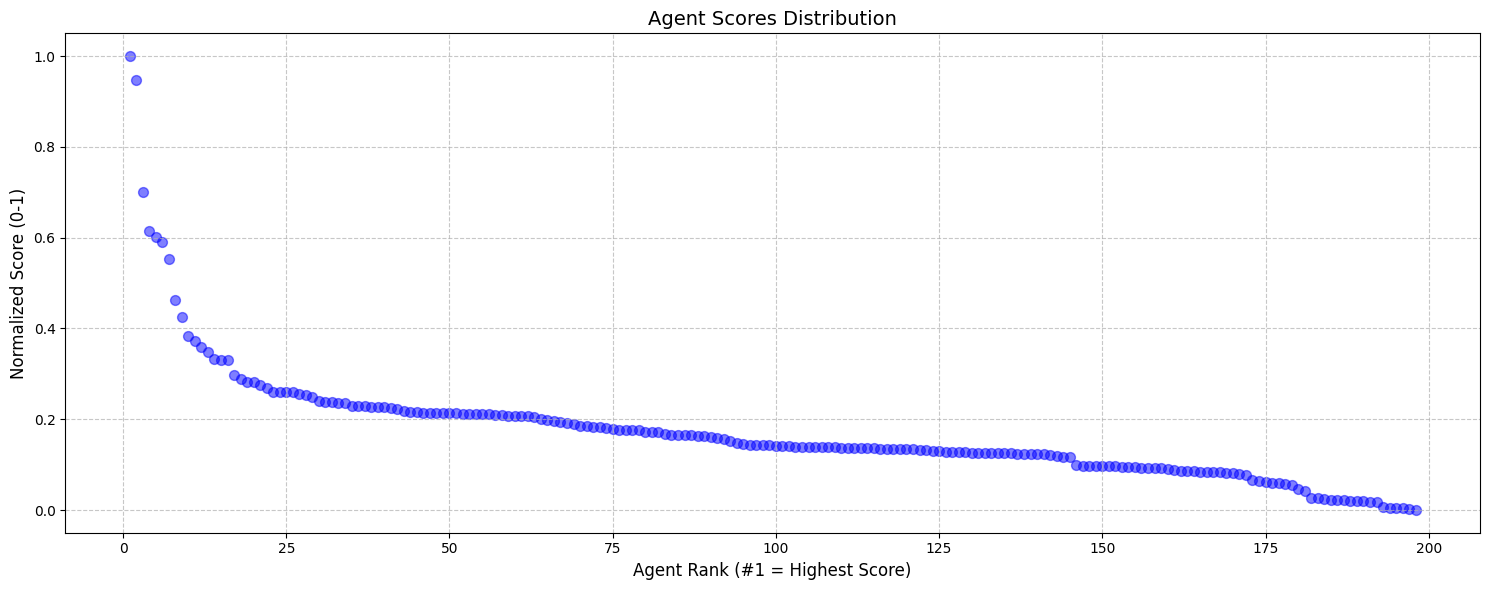


Score Statistics:
count   198.00
mean      0.17
std       0.14
min       0.00
25%       0.10
50%       0.14
75%       0.21
max       1.00
Name: normalized_score, dtype: float64


In [42]:
# Set figure size
plt.figure(figsize=(15, 6))

# Sort values descending for the plot
sorted_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Create scatter plot with inverted rank numbers
plt.scatter(range(1, len(sorted_scores) + 1), sorted_scores['normalized_score'], 
           c='blue', alpha=0.5, s=50)

# Customize the plot
plt.title('Agent Scores Distribution', fontsize=14)
plt.xlabel('Agent Rank (#1 = Highest Score)', fontsize=12)
plt.ylabel('Normalized Score (0-1)', fontsize=12)

# Set y-axis limits
plt.ylim(-0.05, 1.05)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print statistics
print("\nScore Statistics:")
print(sorted_scores['normalized_score'].describe().round(3))